In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical, plot_model

from sklearn.model_selection import train_test_split

Why we see two 'branches' while comparing t_opt with t_pred? 

Here I repeated the task for two centered 2D normal distribuitons, so that the problem was easier to analyze.

## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2-mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2 
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

2d cause then we can draw it

In [4]:
np.random.seed(1234)
n = 10000
mu1 = np.array([0, 0])
mu2 = np.array([0, 0])
Sigma1 = np.array([[1, 0.5], [0.5, 1]])
Sigma2 = np.array([[1, -0.5], [-0.5, 1]])
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

In [5]:
def DV_fun(y, t):
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [6]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

0.6666666666666665

In [7]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

0.6688109449953747

### c)

In [8]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [9]:
x.shape

(20000, 2)

In [10]:
keras.utils.set_random_seed(12)

model_inputs = keras.Input(shape=(2,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [14]:
hist = model.fit(x_train, y_train, epochs=250, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0529 - val_loss: 0.0286
Epoch 2/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0271 - val_loss: 0.0131
Epoch 3/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0043
Epoch 4/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: -0.0014
Epoch 5/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6211e-04 - val_loss: -0.0055
Epoch 6/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0039 - val_loss: -0.0089
Epoch 7/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0072 - val_loss: -0.0118
Epoch 8/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0102 - val_loss: -0.0145
Epoch 9/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0129 - val_loss: -0.0171
Epoch 10/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0155 - val_loss: -0.0197
Epoch 11/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0181 - val_loss: -0.0222
Epoch 12/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3

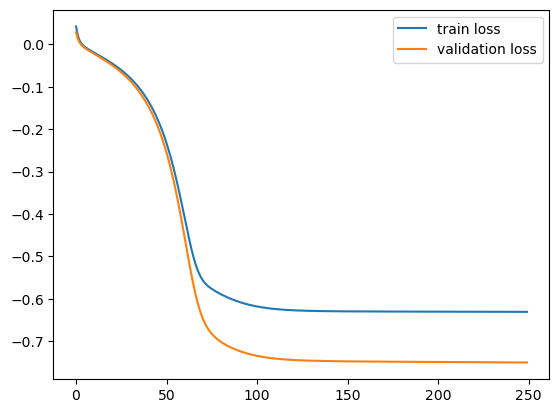

In [15]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

### e)

In [16]:
t_x_pred = model.predict(x)
t_x_pred = t_x_pred[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step


In [17]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

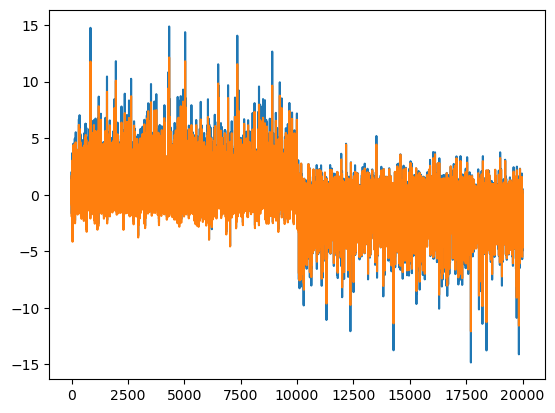

In [18]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)
plt.show()

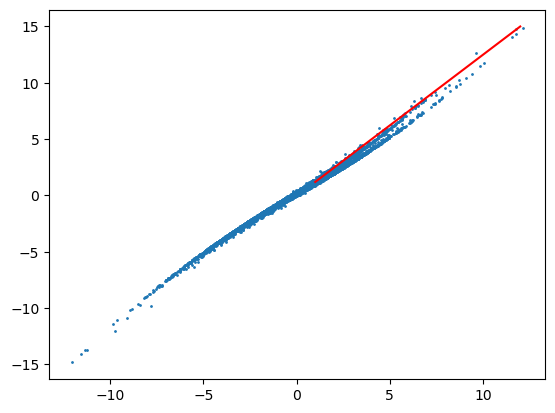

In [19]:
plt.scatter(t_x_pred, t_x_opt, s=1)
x0 = 1
x1 = 12
y0 = 1.2
y1 = 15
plt.plot([x0, x1], [y0, y1], color='red')
plt.show()

In [20]:
a = (y0 - y1)/(x0 - x1)
b =  y0 - a*x0

In [21]:
up_group_den1 = ((t_x_opt > a*t_x_pred + b) & (t_x_pred > x0))
down_group_den1 = ((t_x_opt < a*t_x_pred + b) & (t_x_pred > x0))
others_group_den1 = t_x_pred < x0
others_group_den1[n:] = False
all_den2 = np.concatenate([np.repeat(False, n), np.repeat(True, n)])

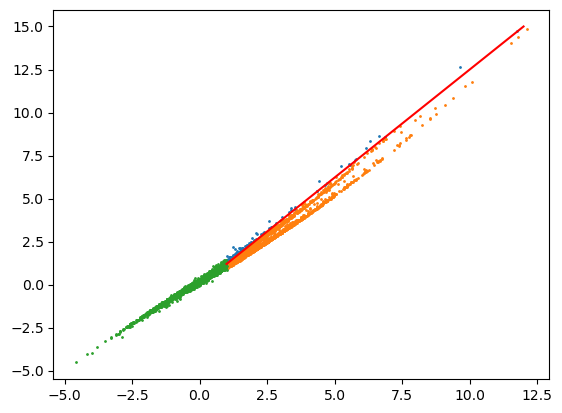

In [22]:
plt.scatter(t_x_pred[up_group_den1], t_x_opt[up_group_den1], s=1)
plt.scatter(t_x_pred[down_group_den1], t_x_opt[down_group_den1], s=1)
plt.scatter(t_x_pred[others_group_den1], t_x_opt[others_group_den1], s=1)
#plt.scatter(t_x_pred[all_den2], t_x_opt[all_den2], s=1)
plt.plot([x0, x1], [y0, y1], color='red')
plt.show()

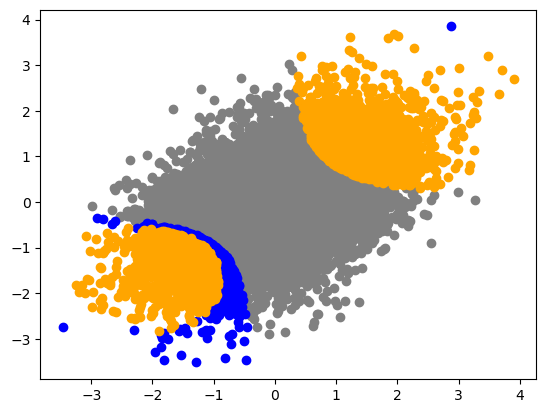

In [23]:
plt.scatter(x[others_group_den1,0],x[others_group_den1,1], color='gray')
plt.scatter(x[up_group_den1,0],x[up_group_den1,1], color='blue')
plt.scatter(x[down_group_den1,0],x[down_group_den1,1], color='orange')
plt.show()

In [24]:
import seaborn as sns

In [25]:
x_grid = np.meshgrid(np.arange(-4, 4, 0.05), np.arange(-4, 4, 0.05), indexing='ij')
x_grid = np.array([np.array(x_grid)[0].flatten(), np.array(x_grid)[1].flatten()]).T

The plot below is symmetric around $x=y$, because we the densities $p$ and $q$ are symmetric around $x=y$ and we compute the values of t_opt using the true densities. Thus, the problem is not with the formula itself. The probles is in the model, as we our input to the model consists of x and the model doesn't know about that symmetry we see, so it fits T to x from bottom left and to x from upper right corner separately (and that's because the errors here and there are not the same).

The fact that we see the problem only for large positive values might be caused by the DV representation (but that's a guess). 

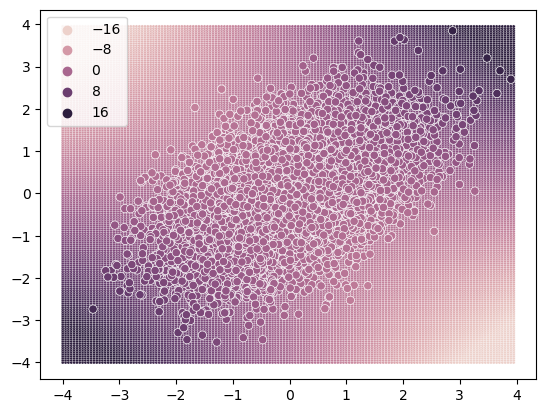

In [26]:
sns.scatterplot(x=x_grid[:,0], y=x_grid[:,1], hue=T_opt(x_grid, mu1, mu2, Sigma1, Sigma2), s=5, hue_norm=(-16, 16))
sns.scatterplot(x=x[:n,0],y=x[:n,1], hue=t_x_opt[:n], legend=False, hue_norm=(-16, 16))
# sns.scatterplot(x=x[n:,0],y=x[n:,1], hue=t_x_opt[n:], legend=False, hue_norm=(-16, 16))
plt.show()

### f)

In [27]:
def nwj_representation_loss(y_true, T_x):
    subs_ytrue = tf.subtract(tf.convert_to_tensor(1.0), y_true)

    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(subs_ytrue)
    
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x,y_true)) / n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x),subs_ytrue)) / n2
    kl_div = -(first_term - second_term)
    
    return kl_div

In [30]:
def nwj_representation_fun(y, t):

    return np.mean(t*y) - np.mean(np.exp(t)*(1-y))

In [31]:
nwj_representation_fun(y, t_x_opt + 1)

-0.5202050257577849

In [32]:
keras.utils.set_random_seed(12)

model_inputs = keras.Input(shape=(2,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model_2 = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=0.01)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_2.compile(optimizer=optimizer, loss=nwj_representation_loss)

In [33]:
model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [35]:
hist = model_2.fit(x_train, y_train, epochs=250, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0535 - val_loss: 1.0288
Epoch 2/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0272 - val_loss: 1.0131
Epoch 3/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0136 - val_loss: 1.0042
Epoch 4/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0055 - val_loss: 0.9985
Epoch 5/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0001 - val_loss: 0.9944
Epoch 6/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9961 - val_loss: 0.9910
Epoch 7/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9927 - val_loss: 0.9881
Epoch 8/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9898 - val_loss: 0.9854
Epoch 9/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9871 - val_loss: 0.9828
Epoch 10/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9844 - val_loss: 0.9802
Epoch 11/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9819 - val_loss: 0.9777
Epoch 12/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

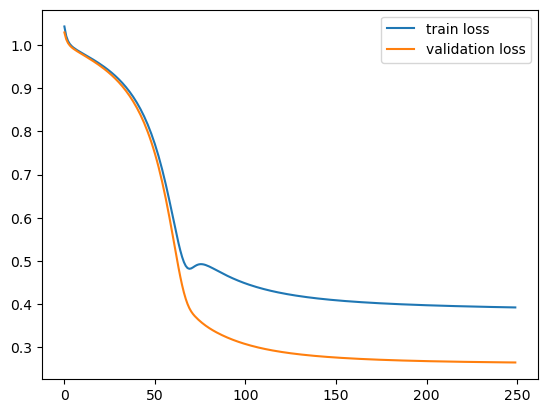

In [36]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [37]:
t_x_pred_2 = model_2.predict(x)
t_x_pred_2 = t_x_pred_2[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step


In [38]:
t_x_opt_2 = T_opt(x, mu1, mu2, Sigma1, Sigma2)

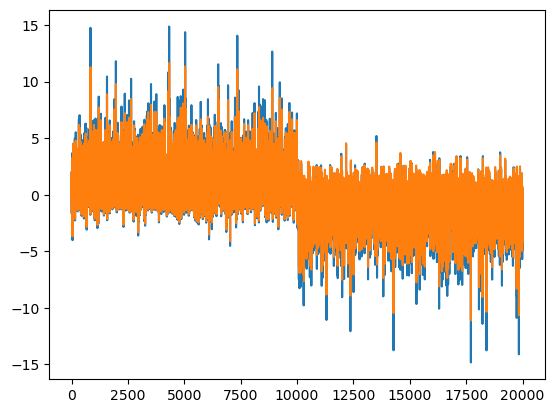

In [39]:
plt.plot(t_x_opt_2)
plt.plot(t_x_pred_2)
plt.show()

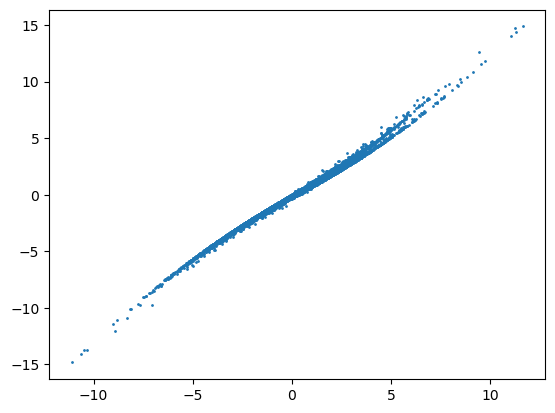

In [41]:
plt.scatter(t_x_pred_2, t_x_opt_2, s=1)
x0 = 1
x1 = 12
y0 = 1.2
y1 = 15
# plt.plot([x0, x1], [y0, y1], color='red')
plt.show()

In [44]:
nwj_representation_fun(y, t_x_pred_2), DV_fun(y, t_x_pred_2)

(-0.17580534616469046, 0.6537576419624735)

In [45]:
nwj_representation_fun(y, t_x_opt_2), DV_fun(y, t_x_opt_2)

(-0.16560152528500455, 0.6688109449953747)